### NPPC signature in python:
1. small cell v.s. not small cell (not small cell == IAC + adeno)
2. small cell v.s. adeno
3. iac v.s. adeno

In [2]:
# %load startup_script.py

# numerical & stats 
import pandas as pd
import numpy as np
from scipy import stats

# plotting
from matplotlib import pyplot as plt

# machine learning
from sklearn import linear_model

# jupyte notebook amenities
%matplotlib inline
%autosave 10

Autosaving every 10 seconds


In [11]:
WCDT_mRNA = "./data/WCDT_mRNA.tsv"
WCDT_clinical = "./data/WCDT_clinical.tsv"
df_mRNA = pd.read_csv(WCDT_mRNA, delimiter="\t")
df_clinical = pd.read_csv(WCDT_clinical, delimiter="\t")

In [53]:
def extract_label(df_clinical):
    # extract information from classification #1
    y_df = df_clinical[["Patient ID", "Classification #1",]].copy()
    y_df.rename(columns={"Classification #1":"NEPC_label", "Patient ID": "Patient_ID"}, inplace=True)
    y_df = y_df[y_df["NEPC_label"]!="Exclude"].copy()
    
    # uniform various naming discrepancies
    y_df.set_index("Patient_ID", inplace=True)
    y_df[y_df["NEPC_label"].isin(["Small cell", "Small Cell"])] = "scnc"
    y_df[y_df["NEPC_label"].isin(["Adenocarcinoma", "Adeno"])] = "adeno"
    y_df[y_df["NEPC_label"].isin(["IAC"])] = "iac"
    return y_df

In [54]:
def data_prep(x=df_mRNA, y=df_clinical, group0=["adeno"], group1=["scnc"]):
    """ 
    extract the samples in label group zero v.s. label group one, 
    in training, the former is assigned a label of 0 and the latter is asigned a label of 1
    """
    # extract desired groups from y
    y = extract_label(df_clinical)
    y[y["NEPC_label"].isin(group1)] = 1
    y[y["NEPC_label"].isin(group0)] = 0
    y = y[y["NEPC_label"].isin([0, 1])]

    # get sample overlap between mRNA and y
    X = df_mRNA.set_index("gene_id").transpose()
    overlap = set(X.index).intersection(set(y.index))
    y = y[y.index.isin(overlap)]
    X = X[X.index.isin(overlap)]
    
    # order X and Y so that same sample name match up
    X.sort_index(inplace=True)
    y.sort_index(inplace=True)
    assert(list(X.index) == list(y.index))
    
    return X, y    

In [55]:
def calc_signature(X, y, classifier=linear_model.LogisticRegression()):
    classifier.fit(X, np.array(list(y['NEPC_label'])))
    return pd.DataFrame(index=X.columns, data=classifier.coef_[0], columns=["python"])

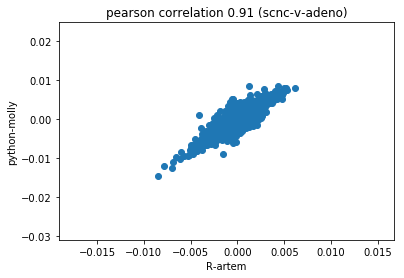

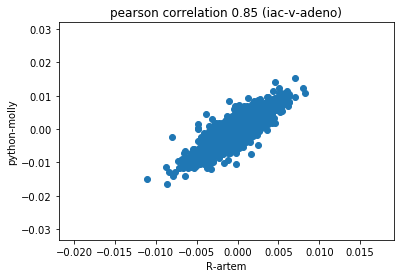

In [61]:
# Comparison with Artem's NEPC signature
for comparison in ["scnc-v-adeno", "iac-v-adeno"]:
    # get python gene signature
    group0 = comparison.split("-")[-1]
    group1 = comparison.split("-")[0]
    X, y = data_prep(group0=[group0], group1=[group1])
    python_sig = calc_signature(X, y)
    
    # get gene overlap between artem signature and python signature
    artem_file = "data/NEPC/{0}-20k-sig.rnk".format(comparison)
    artem_sig = pd.read_csv(artem_file, delimiter="\t", names=["gene","artem"], index_col=0)
    sigs = pd.concat([python_sig, artem_sig], axis=1, join="inner")
    
    # plot
    plt.figure(comparison)
    plt.scatter(sigs["artem"], sigs["python"])
    plt.title("pearson correlation %.2f (%s)" %(stats.pearsonr(sigs["artem"], sigs["python"])[0], comparison))
    plt.xlabel("R-artem")
    plt.ylabel("python-molly")